In [162]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [163]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [164]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3228 non-null   object 
 1   Open       3228 non-null   float64
 2   High       3228 non-null   float64
 3   Low        3228 non-null   float64
 4   Close      3228 non-null   float64
 5   Adj Close  3228 non-null   float64
 6   Volume     3228 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 176.7+ KB


# Preprocessing

In [166]:
# 'Date' 열을 datetime 형태로 변환
df['Date'] = pd.to_datetime(df['Date'])

# 'Date' 열을 인덱스로 설정
df.set_index('Date', inplace=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [167]:
# 변수 설정
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target_variable = 'Adj Close'

In [168]:
X = df[features]
y = df[target_variable]

In [169]:
# 입력값 크기 조정하기 위해 표준 스케일러 사용
# input 중 op,hi,lo는 가격을 의미하고 v는 거래량을 의미해 다른 사이즈를 맞추는 작업

SS = StandardScaler()
input_scaled=SS.fit_transform(X)

In [170]:
# 시계열 데이터 분할
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

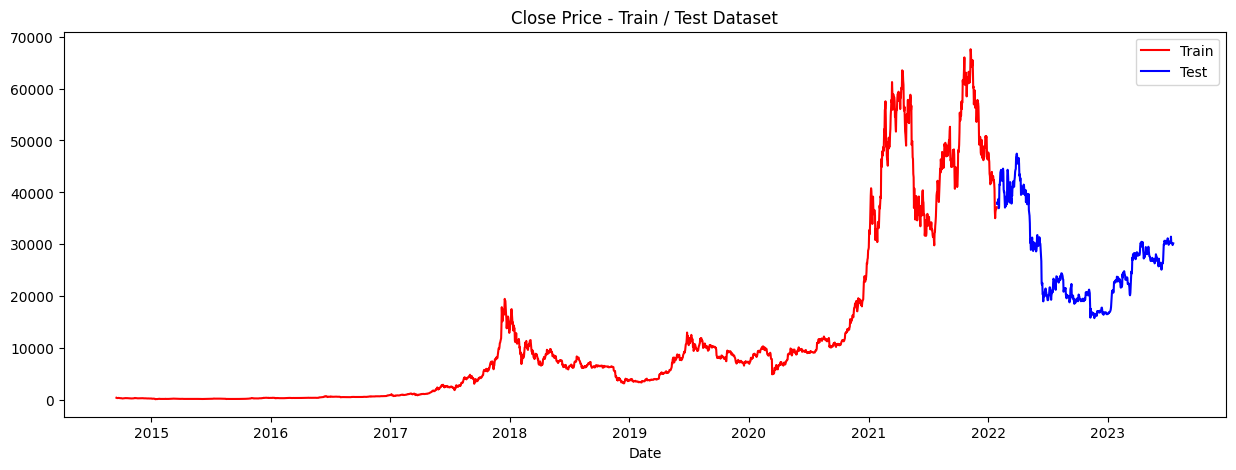

In [171]:
fig, ax = plt.subplots(figsize=(15, 5))

# 데이터셋 비율 그래프 그리기
ax.plot(X_train.index, y_train, label='Train', color='red')
ax.plot(X_test.index, y_test, label='Test', color='blue')

plt.xlabel('Date')
plt.title('Close Price - Train / Test Dataset')
plt.legend()
plt.show()

In [172]:
train_ratio = len(X_train) / len(X) * 100
test_ratio = len(X_test) / len(X) * 100

print(f'Train dataset ratio: {train_ratio:.2f}%')
print(f'Test dataset ratio: {test_ratio:.2f}%')

Train dataset ratio: 83.33%
Test dataset ratio: 16.67%


# Modeling _ RandomForest

In [173]:
# 모델 훈련
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2, random_state=5)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=5)

In [174]:
# 예측
predictions = rf.predict(X_test)

In [175]:
# 모델 평가
errors = np.sqrt(mean_squared_error(predictions, y_test))
print('RMSE:', errors)
print('R^2 Score - Coefficient of Determination', rf.score(X_test, y_test))

RMSE: 392.1850254437749
R^2 Score - Coefficient of Determination 0.9976476784246887


# Visualization

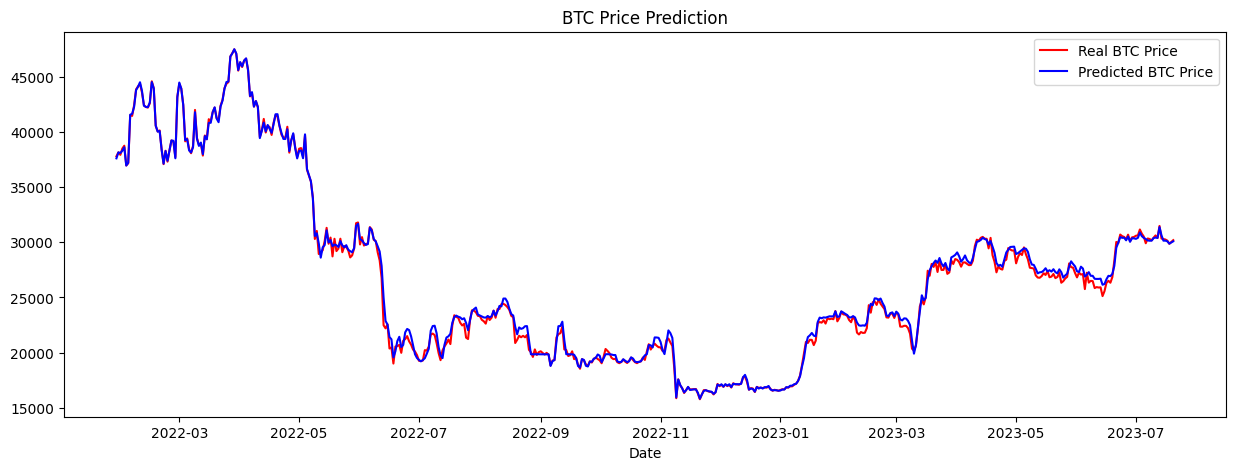

In [182]:
df_result = pd.DataFrame({'Pred': predictions, 'Real': y_test})
df_result['Date'] = X_test.index
df_result.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_result.index, df_result['Real'], label='Real BTC Price', color='red')
ax.plot(df_result.index, df_result['Pred'], label='Predicted BTC Price', color='blue')
plt.xlabel('Date')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

In [185]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# 교차 검증 수행
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2, random_state=5)

# RMSE를 스코어 함수로 사용
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 교차 검증 스코어 계산
cv_scores = cross_val_score(rf, X, y, cv=tscv, scoring=scorer)
print('Cross-Validation RMSE Scores:', np.sqrt(-cv_scores))

Cross-Validation RMSE Scores: [ 1144.78141387  4372.58731327    64.94312532 25255.10535257
   392.18502544]
